# Appendix F4: sWeights

We show four ways of computing sWeights, from the classic methods described in the [sPlot paper](https://doi.org/10.1016/j.nima.2005.08.106) to the new methods via direct integration derived by Michael Schmelling. The find that the best method, the summation method, is not what is commonly used, despite being simple to apply.

## Generate and visualize toy data sets

We use a classic toy example to illustrate with a discriminant variable m ("invariant mass") and a control variable t ("decay time"). The signal in the m distribution is a gaussian, the background is exponential. In the t variable it is vice versa, the signal is exponential and the background is a (broad) gaussian.

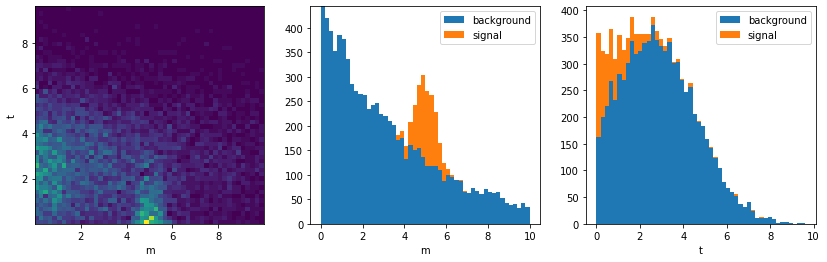

In [1]:
# !pip install matplotlib numpy scipy iminuit
import numpy as np
from scipy.stats import norm, expon, poisson
from matplotlib import pyplot as plt

np.random.seed(1)  # fix seed

# true parameters for signal and background
truth_n_sig = 1000
truth_n_bkg = 10000
truth_sig_m = (5.0, 0.5)
truth_bkg_m = (4.,)
truth_sig_t = (1.0,)
truth_bkg_t = (2.5, 2.0)

# make a data set
m = np.empty(truth_n_sig + truth_n_bkg)
t = np.empty_like(m)

# fill m variables
m[:truth_n_sig] = norm(*truth_sig_m).rvs(truth_n_sig)
m[truth_n_sig:] = expon(0, *truth_bkg_m).rvs(truth_n_bkg)

# fill t variables
t[:truth_n_sig] = expon(0, *truth_sig_t).rvs(truth_n_sig)
t[truth_n_sig:] = norm(*truth_bkg_t).rvs(truth_n_bkg)

# cut out range (0, 10) in m, t
xrange = (0, 10)
ma = (0 < m) & (m < 10) & (0 < t) & (t < 10)
m = m[ma]
t = t[ma]

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].hist2d(m, t, bins=(50, 50))
ax[0].set_xlabel("m")
ax[0].set_ylabel("t")
ax[1].hist((m[truth_n_sig:], m[:truth_n_sig]), bins=50, stacked=True, label=("background", "signal"))
ax[1].set_xlabel("m")
ax[1].legend()
ax[2].hist((t[truth_n_sig:], t[:truth_n_sig]), bins=50, stacked=True, label=("background", "signal"))
ax[2].set_xlabel("t")
ax[2].legend();

## Fit toy data set

In [2]:
from iminuit import Minuit
import numba as nb


# extended likelihood
def nll(n_sig, n_bkg, mu, sigma, lambd):
    s = norm(mu, sigma)
    b = expon(0, lambd)
    # normalisation factors are needed for pdfs, since x range is restricted
    sn = np.diff(s.cdf(xrange))
    bn = np.diff(b.cdf(xrange))
    no = n_sig + n_bkg
    return no - np.sum(np.log(s.pdf(m) / sn * n_sig + b.pdf(m) / bn * n_bkg))


mi = Minuit(nll,
            n_sig=truth_n_sig, n_bkg=truth_n_bkg,
            mu=truth_sig_m[0], sigma=truth_sig_m[1], lambd=truth_bkg_m[0],
            errordef=Minuit.LIKELIHOOD,
            pedantic=False)

display(mi.migrad())
mi.hesse()

par = mi.np_values()
cov = mi.np_covariance()

------------------------------------------------------------------
| FCN = -5.594E+04              |     Ncalls=122 (122 total)     |
| EDM = 3.62E-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | n_sig |    990    |    60     |            |            |         |         |       |
| 1 | n_bkg |  0.827E4  |  0.010E4  |            |            |         |         |       |
| 2 | mu    |   5.023   |   0.027   |            |            |         |         |       |
| 3 | sigma |   0.456   |   0.026   |            |            |         |         |       |
| 4 | lambd |   3.96    |   0.07    |            |            |         |         |       |
-------------------------------------------------------------------------------------------

### Visualize fitted model

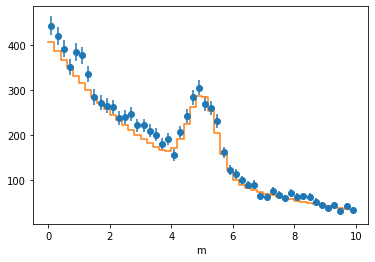

In [3]:
def cdf(m):
    n_sig, n_bkg, mu, sigma, lambd = par
    s = norm(mu, sigma)
    b = expon(0, lambd)
    return n_sig * s.cdf(m) + n_bkg * b.cdf(m)


w, xe = np.histogram(m, bins=50, range=xrange)
cx = 0.5 * (xe[1:] + xe[:-1])
plt.errorbar(cx, w, w ** 0.5, fmt="o")
plt.step(xe[:-1], np.diff(cdf(xe)), where="post")
plt.xlabel("m");

## Compute W matrix

### Compute W via integration (Schmelling method)

In [4]:
from scipy.integrate import quad
from scipy.linalg import solve


def d_sig(m):
    d = norm(*par[2:4])
    return d.pdf(m) / (d.cdf(xrange[1]) - d.cdf(xrange[0]))


def d_bkg(m):
    d = expon(0, par[4])
    return d.pdf(m) / (d.cdf(xrange[1]) - d.cdf(xrange[0]))


# compute W matrix via numerical integration
n_sig, n_bkg = par[:2]
W = np.zeros((2, 2))
d = [d_sig, d_bkg]

# fill upper triangle of symmetric matrix, the lower triangle is redundant
for j, di in enumerate(d):
    for i, dj in enumerate(d[:j+1]):
        W[i, j] = quad(lambda m: di(m) * dj(m) / (n_sig * d_sig(m) + n_bkg * d_bkg(m)),
                       *xrange)[0]

print("W matrix")
print(W)

# this uses only the upper triangle
alpha, beta = solve(W, np.eye(2), sym_pos=True)
print(f"alpha_sig = {alpha[0]:.2f}")
print(f"alpha_bkg = {alpha[1]:.2f}")


def w_sig(m):
    return ((alpha[0] * d_sig(m) + alpha[1] * d_bkg(m)) /
            (n_sig * d_sig(m) + n_bkg * d_bkg(m)))


w_s_integration = w_sig(m)

print("check that integral w_sig(m) * d_bkg(m) dm is close to zero:",
      quad(lambda m: d_bkg(m) * w_sig(m), *xrange)[0])
print("check that integral w_sig(m) * d_sig(m) dm is close to one:",
      quad(lambda m: d_sig(m) * w_sig(m), *xrange)[0])
print(f"check sum(w_s) = {np.sum(w_s_integration):.2f} is close to n_sig = {n_sig:.2f}")

# weighted maximum-likelihood estimator for parameter of exponential signal in t
hat_lambd_sig = np.sum(t * w_s_integration) / np.sum(w_s_integration)
print(f"hat_lambd_sig = {hat_lambd_sig:.2f} (true value is {truth_sig_t[0]})")

W matrix
[[4.69321315e-04 6.45531852e-05]
 [0.00000000e+00 1.13218057e-04]]
alpha_sig = 2312.06
alpha_bkg = -1318.26
check that integral w_sig(m) * d_bkg(m) dm is close to zero: 2.5999341568549994e-13
check that integral w_sig(m) * d_sig(m) dm is close to one: 0.9999999999998612
check sum(w_s) = 994.06 is close to n_sig = 993.80
hat_lambd_sig = 1.00 (true value is 1.0)


### Compute via summation (classic sPlot)

This is using Eq. 10 of the [original sPlot paper](https://doi.org/10.1016/j.nima.2005.08.106), which is the same as the integration method with the [empirical pdf](https://en.wikipedia.org/wiki/Empirical_distribution_function) weighted with the inverse of the probability density inserted, which produces a uniform importance sampling of the integral:

$$
\frac{1}{N} \sum_i \frac{\delta(m - m_i)}{n_\mathrm{sig} d_\mathrm{sig}(m) + n_\mathrm{bkg} d_\mathrm{bkg}(m)}
$$

This calculation avoid the numerical integration and any associated numerical issues, but has lower accuracy than numerical integration.

In [5]:
# compute W matrix without numerical integration
W = np.zeros((2, 2))

# fill upper triangle of symmetric matrix, the lower triangle is redundant
for j, di in enumerate(d):
    for i, dj in enumerate(d[:j+1]):
        W[i, j] = np.sum(
            di(m) * dj(m) / (n_sig * d_sig(m) + n_bkg * d_bkg(m))**2)

print("W matrix")
print(W)

# this uses only the upper triangle
alpha, beta = solve(W, np.eye(2), sym_pos=True)
print(f"alpha_sig = {alpha[0]:.2f}")
print(f"alpha_bkg = {alpha[1]:.2f}")
print(f"beta_sig = {beta[0]:.2f}")
print(f"beta_bkg = {beta[1]:.2f}")


def w_sig(m):
    return ((alpha[0] * d_sig(m) + alpha[1] * d_bkg(m)) /
            (n_sig * d_sig(m) + n_bkg * d_bkg(m)))


def w_bkg(m):
    return ((beta[0] * d_sig(m) + beta[1] * d_bkg(m)) /
            (n_sig * d_sig(m) + n_bkg * d_bkg(m)))


w_s_sum = w_sig(m)

print("check: integral w_sig(m) * d_bkg(m) dm is close to zero:",
      quad(lambda m: d_bkg(m) * w_sig(m), *xrange)[0])
print("check: integral w_sig(m) * d_sig(m) dm is close to one:",
      quad(lambda m: d_sig(m) * w_sig(m), *xrange)[0])
print(
    f"check: sum(w_s) = {np.sum(w_s_sum):.2f} is close to n_sig = {n_sig:.2f}")

# weighted maximum-likelihood estimator for parameter of exponential signal in t
hat_lambd_sig = np.sum(t * w_s_sum) / np.sum(w_s_sum)
print(f"hat_lambd_sig = {hat_lambd_sig:.2f} (true value is {truth_sig_t[0]})")

W matrix
[[4.69269478e-04 6.45745533e-05]
 [0.00000000e+00 1.13218337e-04]]
alpha_sig = 2312.46
alpha_bkg = -1318.92
beta_sig = -1318.92
beta_bkg = 9584.75
check: integral w_sig(m) * d_bkg(m) dm is close to zero: -4.904369546685286e-05
check: integral w_sig(m) * d_sig(m) dm is close to one: 1.0001480523954607
check: sum(w_s) = 993.80 is close to n_sig = 993.80
hat_lambd_sig = 0.99 (true value is 1.0)


While we find that the numerical checks of orthonormality produce less accurate results, this method reproduces the original fit result with the highest accuracy as can be seen from `sum(w_s_sum) == n_sig`. In practice, the accuracy is good enough unless the event sample is very small.

### Visualize results

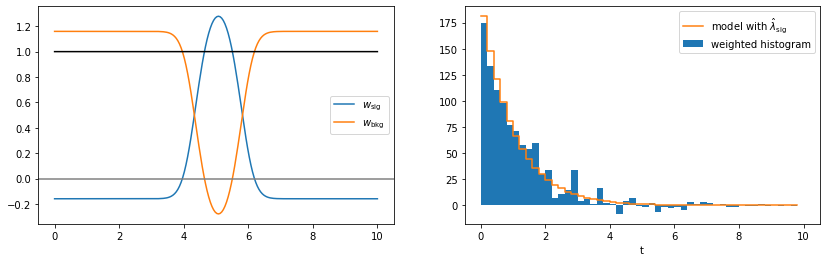

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plt.sca(ax[0])
m1 = np.linspace(*xrange, 200)
plt.plot(m1, w_sig(m1), label="$w_\\mathrm{sig}$")
plt.plot(m1, w_bkg(m1), label="$w_\\mathrm{bkg}$")
plt.plot(m1, w_sig(m1) + w_bkg(m1), "-k")
plt.axhline(0, color="0.5")
plt.legend()
plt.sca(ax[1])
_, xe, *_ = plt.hist(t, bins=50, range=xrange, weights=w_s_sum,
                     label="weighted histogram")
t1 = np.linspace(*xrange)
tcdf = expon(0, hat_lambd_sig).cdf(xe)
plt.step(xe[:-1], np.diff(tcdf) * np.sum(w_s_sum), where="post",
         label="model with $\hat\lambda_\\mathrm{sig}$")
plt.xlabel("t")
plt.legend();

## Compute sWeights from covariance matrix

The [original sPlot paper](https://doi.org/10.1016/j.nima.2005.08.106) already mentions a shortcut to obtain the sWeights, by using the covariance matrix of a fit, but they also note that this calculation **is less accurate than the direct calculation** shown before. This means the other calculation methods should be preferred.

In practice, it is common to redo the fit with all parameters fixed, except the yields, to obtain the right covariance matrix. That is not necessary. We show here that the same result can be obtained from the original covariance matrix. Steps:

* Invert full covariance matrix
* Cut out the (2 x 2) sub-matrix of yields
* Invert sub-matrix

The matrix obtained in this way is identical to one obtained from a fit with the other parameters fixed (up to numerical errors).

In [7]:
# classic way: fit again with all parameters except yields fixed
for i in range(len(mi.args)):
    mi.fixed[i] = i >= 2
mi.migrad()
cov_refit = mi.np_matrix()

print("covariance matrix from re-fit\n", cov_refit)

# better way: extract sub-matrix without re-fitting
inv_cov = np.linalg.inv(cov)
cov_subhessian = np.linalg.inv(inv_cov[:2, :2])

print("covariance matrix from sub-hessian\n", cov_subhessian)

covariance matrix from re-fit
 [[ 2311.27892277 -1312.3386796 ]
 [-1312.3386796   9578.11924785]]
covariance matrix from sub-hessian
 [[ 2310.41637914 -1310.9744965 ]
 [-1310.9744965   9576.34664259]]


In [8]:
w_s_refit = (cov_refit[0, 0] * d[0](m) + cov_refit[0, 1] * d[1](m)) / (n_sig * d[0](m) + n_bkg * d[1](m))
w_s_subhessian = (cov_subhessian[0, 0] * d[0](m) + cov_subhessian[0, 1] * d[1](m)) / (n_sig * d[0](m) + n_bkg * d[1](m))

In [9]:
print("n_sig from original fit             ", n_sig)
print("sum(w_s) [obtained from integration]", np.sum(w_s_integration))
print("sum(w_s) [obtained from summation]  ", np.sum(w_s_sum))
print("sum(w_s) [obtained from re-fit]     ", np.sum(w_s_refit))
print("sum(w_s) [obtained from sub-hessian]", np.sum(w_s_subhessian))

n_sig from original fit              993.7988387239785
sum(w_s) [obtained from integration] 994.0570585856073
sum(w_s) [obtained from summation]   993.7988387239791
sum(w_s) [obtained from re-fit]      999.1985050536103
sum(w_s) [obtained from sub-hessian] 999.7000687383012


The results are similar, but we find deviations in the normalization of sWeights. The sWeights from summation are recommended because they best reproduce the yield obtained from the original fit, which is self-consistent. This computation is also straight-forward and the recommended method of calculation from the original sPlot paper.

## Test of zero correlation is not a test of independence

Applying the sWeights method requires a factorization (independence) of the two variables m and t in signal and background. Instead of a proper test of independence, the correlation of the two variables is often checked.

Zero correlation is a necessary but not sufficient condition for independence.

In [10]:
# correlation of m and t in this example
np.cov(m, t)[0, 1] / np.sqrt(np.var(m) * np.var(t))

-0.07982981900398102